### `Finetune LLM to generate response on Amazon product description and Product name based on custom dataset`

In [2]:
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv(r"C:\Desktop\LLM Finetuning\Dataset\amazon_product_details.csv", usecols=['category', 'about_product', 'product_name'])
data.head()

,product_name,category,about_product
0,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,High Compatibility : Compatible With iPhone 12...
1,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,"Compatible with all Type C enabled devices, be..."
2,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,【 Fast Charger& Data Sync】-With built-in safet...
3,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,The boAt Deuce USB 300 2 in 1 cable is compati...
4,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,[CHARGE & SYNC FUNCTION]- This cable comes wit...


In [3]:
data['category'] = data['category'].apply(lambda x: x.split('|')[-1])

In [4]:
data

,product_name,category,about_product
0,Wayona Nylon Braided USB to Lightning Fast Cha...,USBCables,High Compatibility : Compatible With iPhone 12...
1,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,USBCables,"Compatible with all Type C enabled devices, be..."
2,Sounce Fast Phone Charging Cable & Data Sync U...,USBCables,【 Fast Charger& Data Sync】-With built-in safet...
3,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,USBCables,The boAt Deuce USB 300 2 in 1 cable is compati...
4,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,USBCables,[CHARGE & SYNC FUNCTION]- This cable comes wit...
...,...,...,...
1460,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,WaterPurifierAccessories,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...
1461,Prestige Delight PRWO Electric Rice Cooker (1 ...,Rice&PastaCookers,"230 Volts, 400 watts, 1 Year"
1462,Bajaj Majesty RX10 2000 Watts Heat Convector R...,HeatConvectors,International design and styling|Two heat sett...
1463,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,ExhaustFans,Fan sweep area: 230 MM ; Noise level: (40 - 45...


#### Creating dataframes for product and description separately.

In [5]:
products = data[['category', 'product_name']]
description = data[['category', 'about_product']]

products = products.rename(columns={'product_name': 'text'})
description = description.rename(columns={'about_product': 'text'})

products['task_type'] = 'Product Name'
description['task_type'] = 'Product Description'

In [6]:
data = pd.concat([products, description], ignore_index=True)

#### Train-Test split

In [7]:
dataset = Dataset.from_pandas(data)
dataset = dataset.shuffle(seed=0)
dataset = dataset.train_test_split(test_size=0.1)

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 2637
    })
    test: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 293
    })
})

In [9]:
dataset['test'][2]

{'category': 'USBCables',
 'text': 'Spaceship grade aluminium cable casing ensures long-lasting durability and reliable charging|Length: 2M',
 'task_type': 'Product Description'}


## `Decide the number of tokens to be used for finetuning`
### Choosing optimum number of tokens for Max token length

In [10]:
# 1.5 times of total words
products['text_tokens'] = products['text'].apply(lambda x: len(x.split())*1.5)
description['text_tokens'] = description['text'].apply(lambda x: len(x.split())*1.5)


<Axes: >

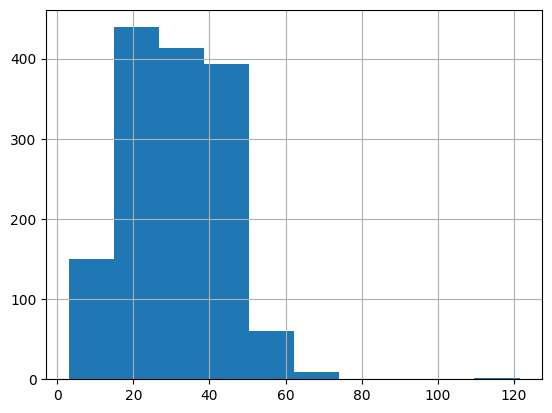

In [11]:
products['text_tokens'].hist()

<Axes: >

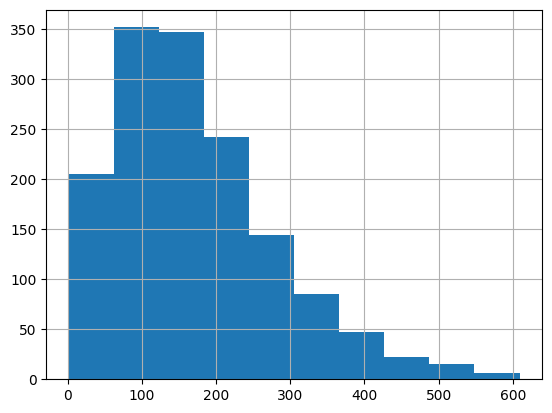

In [12]:
description['text_tokens'].hist()

#### `Token threshold of 500` would be good enough to capture all the tokens in the dataset for better training purpose.

In [13]:
## Data Preparation for tokenization
def formatting_func(example):
    text = f"""
            Given the product category, you need to generate a '{example['task_type']}'.
            ### Category: {example['category']}\n ### {example['task_type']}: {example['text']}

            """
    return text

In [14]:
print(formatting_func(dataset['train'][0]))


            Given the product category, you need to generate a 'Product Name'.
            ### Category: USBCables
 ### Product Name: Amazon Basics USB Type-C to USB-A 2.0 Male Fast Charging Cable for Laptop - 3 Feet (0.9 Meters), Black

            


### `Load Base Model and Tokenizer`

In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "microsoft/phi-2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True,
                                             torch_dtype=torch.float16, quantization_config=bnb_config)

Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.81s/it]


In [16]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_size='left',
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False
)

tokenizer.pad_token = tokenizer.eos_token

In [17]:
max_length = 500

def tokenize(prompt):
  result = tokenizer(
      formatting_func(prompt),
      truncation = True,
      max_length=max_length,
      padding = "max_length"
  )

  result['labels'] = result['input_ids'].copy()

  return result

In [18]:
tokenizer

CodeGenTokenizer(name_or_path='microsoft/phi-2', vocab_size=50257, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50257: AddedToken("                               ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50258: AddedToken("                              ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50259: AddedToken("                             ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50260: AddedToken("                            ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50261:

In [19]:
print(tokenize(dataset['train'][0]))

{'input_ids': [50256, 198, 50276, 15056, 262, 1720, 6536, 11, 345, 761, 284, 7716, 257, 705, 15667, 6530, 4458, 198, 50276, 21017, 21743, 25, 1294, 2749, 2977, 198, 44386, 8721, 6530, 25, 6186, 45884, 8450, 5994, 12, 34, 284, 8450, 12, 32, 362, 13, 15, 12674, 12549, 14797, 278, 20249, 329, 406, 45007, 532, 513, 43391, 357, 15, 13, 24, 3395, 364, 828, 2619, 628, 50276, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,

In [20]:
dataset = dataset.map(tokenize)

Map: 100%|██████████| 293/293 [00:00<00:00, 501.14 examples/s]


### LoRA Config

In [21]:
from peft import LoraConfig, get_peft_model

target_modules = ["Wqkv", "fc1", "fc2"]

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules = target_modules,
    bias = "none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

In [22]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
              (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
              (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
              (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
            )
            (mlp): PhiMLP(
              (activation_fn): NewGELUActivation()
              (fc1): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=10240, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): L

### `No of trainable parameters`

In [23]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [24]:
print_trainable_parameters(model)

trainable params: 26214400 || all params: 1547607040 || trainable%: 1.6938666807822222


In [25]:
from accelerate import Accelerator

accelerator = Accelerator(gradient_accumulation_steps=1)

model = accelerator.prepare_model(model)


In [ ]:
# Trainer, Training Arguments, DataCollator

from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datetime import datetime

project = "phi2-finetune"
run_name = 'train-dir'
output_dir = "./" + run_name

args=TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=10,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=5,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=5,                # Save checkpoints every 25 steps
        eval_strategy="steps", # Evaluate the model every logging step
        eval_steps=5,               # Evaluate and save checkpoints every 25 steps
        do_eval=True,                # Perform evaluation at the end of training
    )

: 

In [ ]:
trainer = Trainer(
    model=model,
    args = args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  
trainer.train().to("cuda")

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    load_in_8bit=True,
    torch_dtype=torch.float16
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False
)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

NameError: name 'AutoModelForCausalLM' is not defined

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, '/train-dir/checkpoint-500')

In [ ]:
eval_prompt = """
Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
"""

model_input = eval_tokenizer(eval_prompt, return_tensors="pt")

ft_model.eval()
with torch.no_grad():
  output = ft_model.generate(**model_input, max_new_tokens=256,
                                           repetition_penalty=1.15)
  result = eval_tokenizer.decode(output[0], skip_special_tokens=True)

  print(result)